## Kernel Galerkin

In [4]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from src.eigensolver.galerkin.galerkin_eigensolver import GalerkinSolver
from src.energy.quadratic import QuadraticEnergy
from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.galerkin.constant_basis import ConstantBasis
from src.eigensolver.galerkin.orthogonal_basis import OrthogonalBasis
from src.eigensolver.galerkin.kernels.gaussian_kernel import GaussianKernel
from src.eigensolver.galerkin.kernels.polynomial_kernel import PolynomialKernel
from src.metrics.eigen_evaluator import EigenEvaluator

In [3]:
def kernel_experiment(experiment_params, kernel_class = GaussianKernel):
    kernel_params = experiment_params['kernel_params']
    solver_params = experiment_params['solver_params']

    np.random.seed(42)
    dim = kernel_params['dim']
    energy = QuadraticEnergy(np.eye(dim))
    x = energy.exact_sample((50000,))

    kernel = kernel_class(kernel_params)

    p = kernel_params['p']
    L_reg = solver_params['L_reg']
    k = solver_params['k']
    
    basis_points = energy.exact_sample((p,))
    basis = KernelBasis(kernel, basis_points)
    basis = ConstantBasis(basis)

    solver = GalerkinSolver(energy, 1.0, solver_params)

    solver = solver.fit(x,basis,k=min(p-1,k),L_reg=L_reg)

    return x, solver

In [4]:
def plot_eigenfunctions(x,solver, k):
    l = 4
    fig, ax = plt.subplots(k//l,l,figsize=(20,k*1.2))
    fx = solver.predict(x)
    Lfx = solver.predict_Lf(x)
    for m in range(k):
        ax[m // l, m % l].hist2d(fx[:,m],Lfx[:,m],bins=50,cmap='viridis')
        ax[m // l, m % l].plot(fx[:,m],fx[:,m]*solver.eigvals[m],color='white')
        ax[m // l, m % l].set_xlabel("f(x)")
        ax[m // l, m % l].set_ylabel("Lf(x)")
        ax[m // l, m % l].set_title(f'Eigenvalue m = {m}, $\\lambda$ = {solver.eigvals[m]:.3f}')

In [5]:
metrics = ['eigen_error','orth_error','eigen_cost', 'eigenvalue_mse','eigenfunc_mse']

In [6]:
experiment_params = {
    'kernel_params': {
        'dim': 2,
        'p': 100,
        'scale': 3.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 6
    }
}

x, solver = kernel_experiment(experiment_params, GaussianKernel)

if solver is None:
    print('Error')
else:
    energy = QuadraticEnergy(np.eye(experiment_params['kernel_params']['dim']))
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [1.34493616e-08 3.92094245e-03 3.36254710e-03 2.49643945e-02
 6.66138748e-02 6.03721977e-02]
orth_error: [3.05636608e-13 1.73871467e-04 7.37676817e-06 6.36839096e-06
 2.56047721e-05]
eigen_cost: [3.57984263e-05 9.88504453e+03 1.00899643e+04 1.97678106e+04
 2.02110554e+04 2.06503321e+04]
eigenvalue_mse: [9.55740831e-13 9.76557989e-05 1.03905832e-04 8.44718600e-05
 2.33638017e-03 3.80111467e-03]
eigenfunc_mse: [8.88658277e-10 4.65341264e-04 5.27384911e-04 1.81409017e-01
 1.82396337e-02 2.00937901e-01]


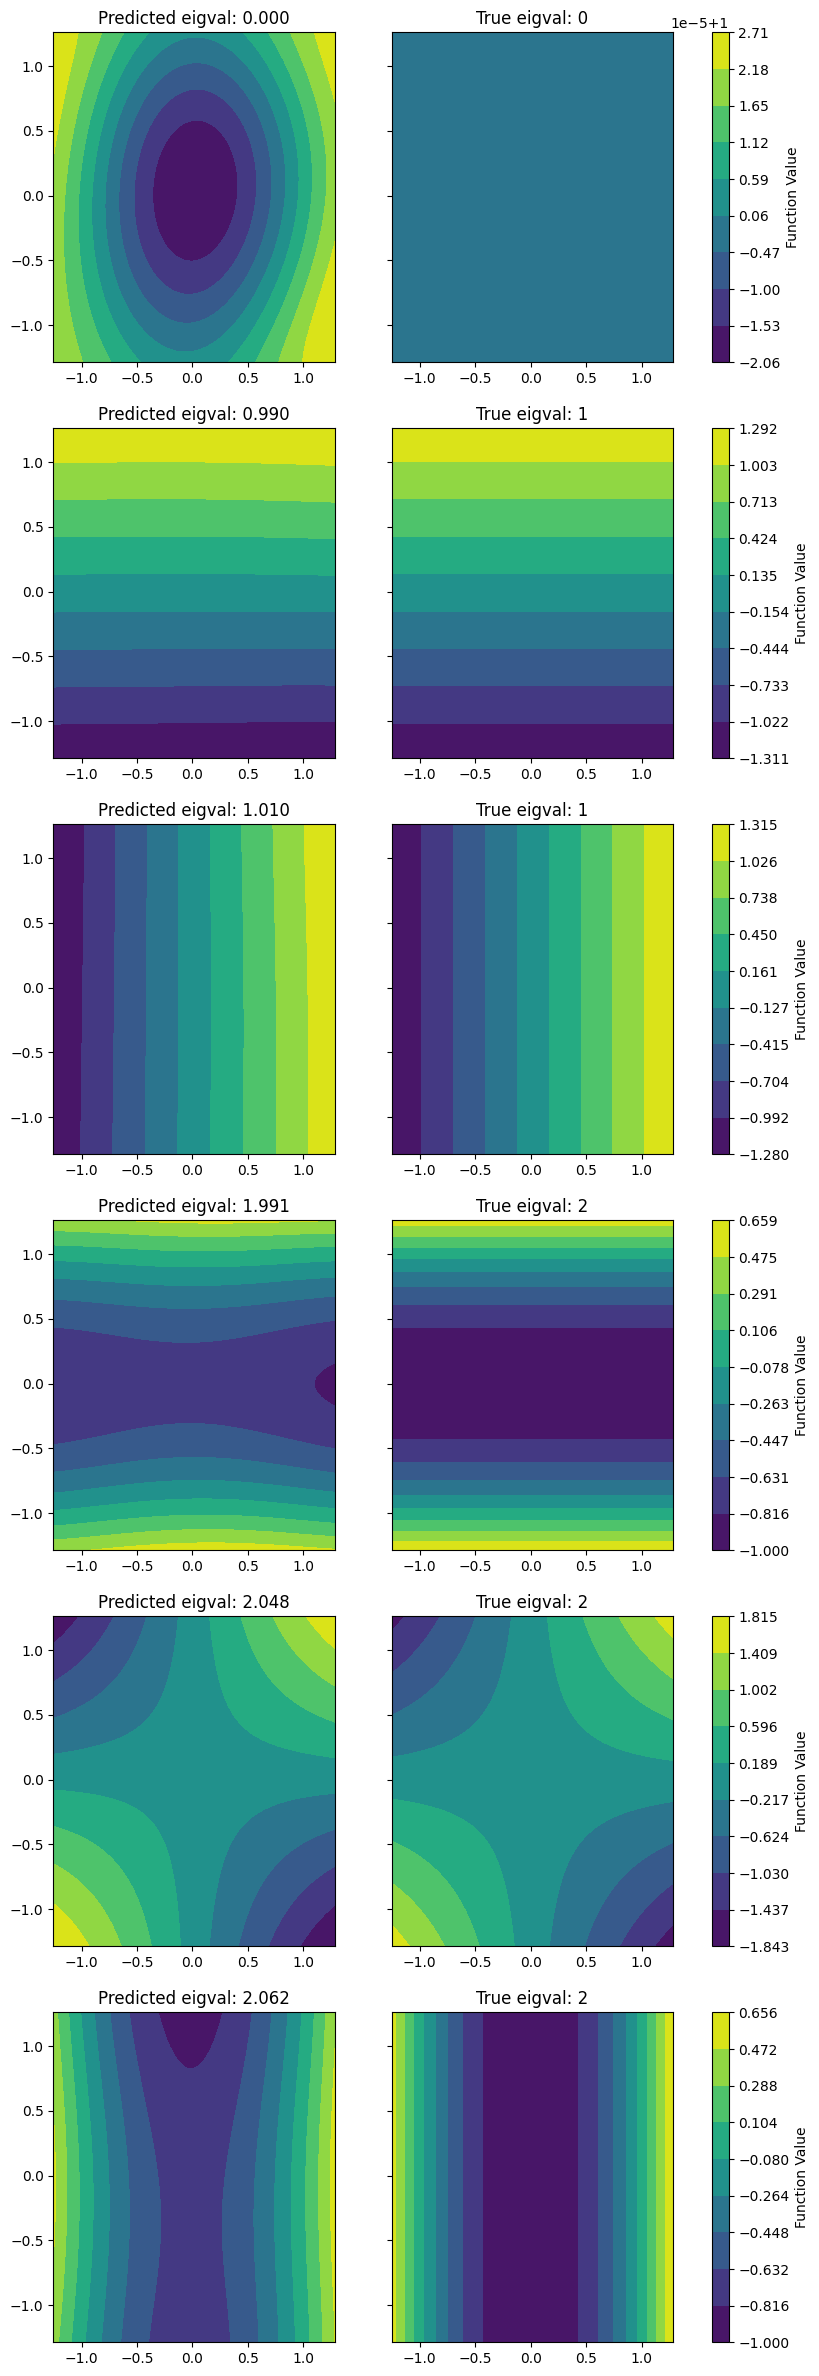

In [29]:
_ = evaluator.plot_eigfuncs(solver,x_eval,6)

### Hyperparameter experiment

In [8]:
experiment_name = 'gaussian'
df = pd.read_csv(f'/home/lclaeys/eigenfunction-solver/experiments/quadratic_energy/{experiment_name}.csv')

In [10]:
metrics = ['eigen_error','orth_error','eigen_cost', 'eigenvalue_mse','eigenfunc_mse']

In [ ]:
pd.pivot_table(df,index='p',columns = 'scale', values = 'eigenvalue_mse')

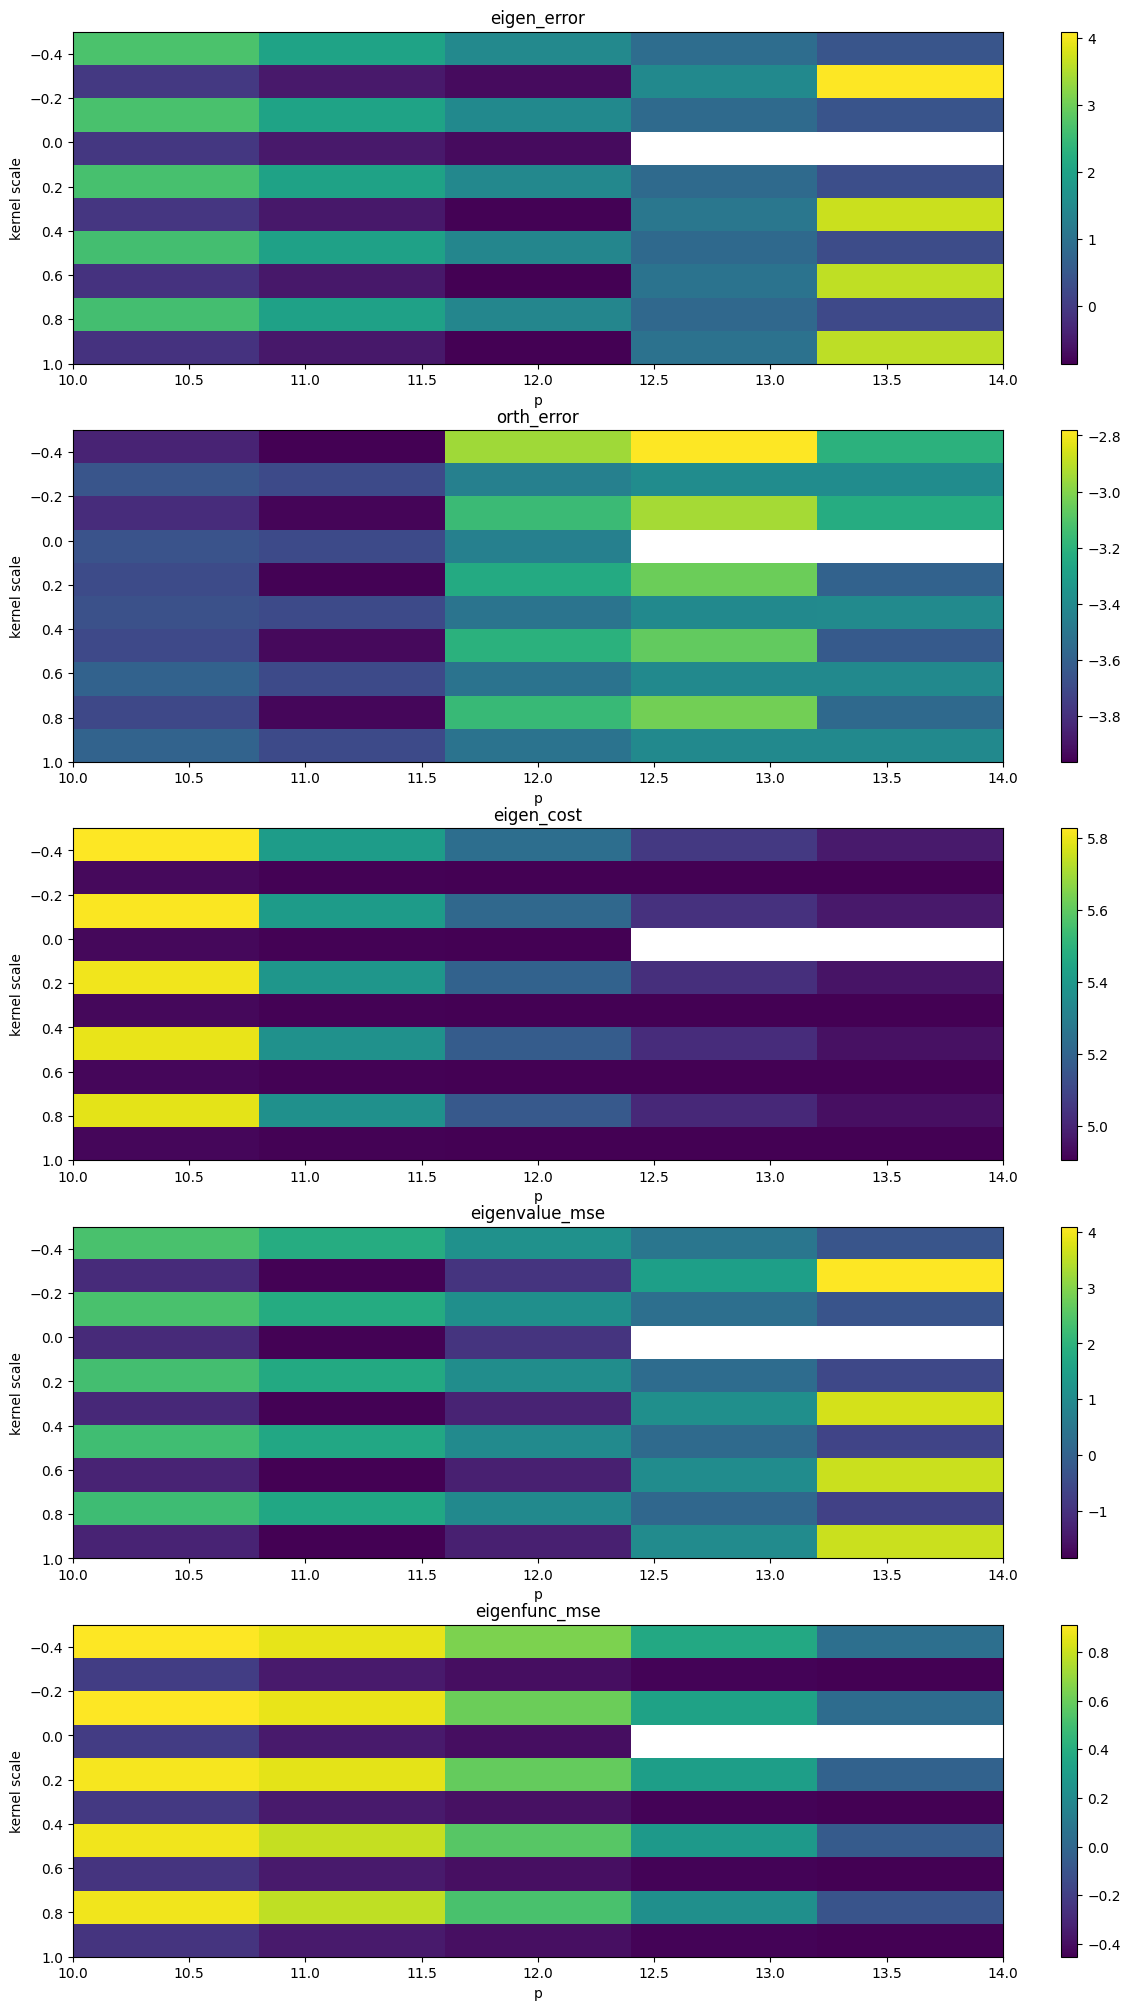

In [53]:
results = results.reshape((len(kernel_scales),len(ps),len(metrics)))

fig, ax = plt.subplots(len(metrics),1,figsize=(15,5*len(metrics)))

for i in range(len(metrics)):
    cax = ax[i].imshow(np.log10(results[:,:,i]),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
    cbar = fig.colorbar(cax, ax=ax[i],shrink=1)
    ax[i].set_title(metrics[i])
    ax[i].set_xlabel('p')
    ax[i].set_ylabel('kernel scale')

In [ ]:

for kernel_scale in tqdm(kernel_scales):
    for p in ps:
        #x, solver = polynomial_kernel_experiment(dim, p, kernel_scale, kernel_order=kernel_order)
        x, solver = gaussian_kernel_experiment(dim, p, kernel_scale)
        
        if solver is not None:
            eigen_errs.append(eigen_error(x,solver,k))
            orth_errs.append(orth_error(x,solver,k))
            L_prod_errs.append(L_prod_error(x,solver,k))
        else:
            eigen_errs.append(np.nan)
            orth_errs.append(np.nan)
            L_prod_errs.append(np.nan)

eigen_errs = np.array(eigen_errs).reshape((len(kernel_scales),len(ps)))
orth_errs = np.array(orth_errs).reshape((len(kernel_scales),len(ps)))
L_prod_errs = np.array(L_prod_errs).reshape((len(kernel_scales),len(ps)))

Text(0, 0.5, 'kernel scale')

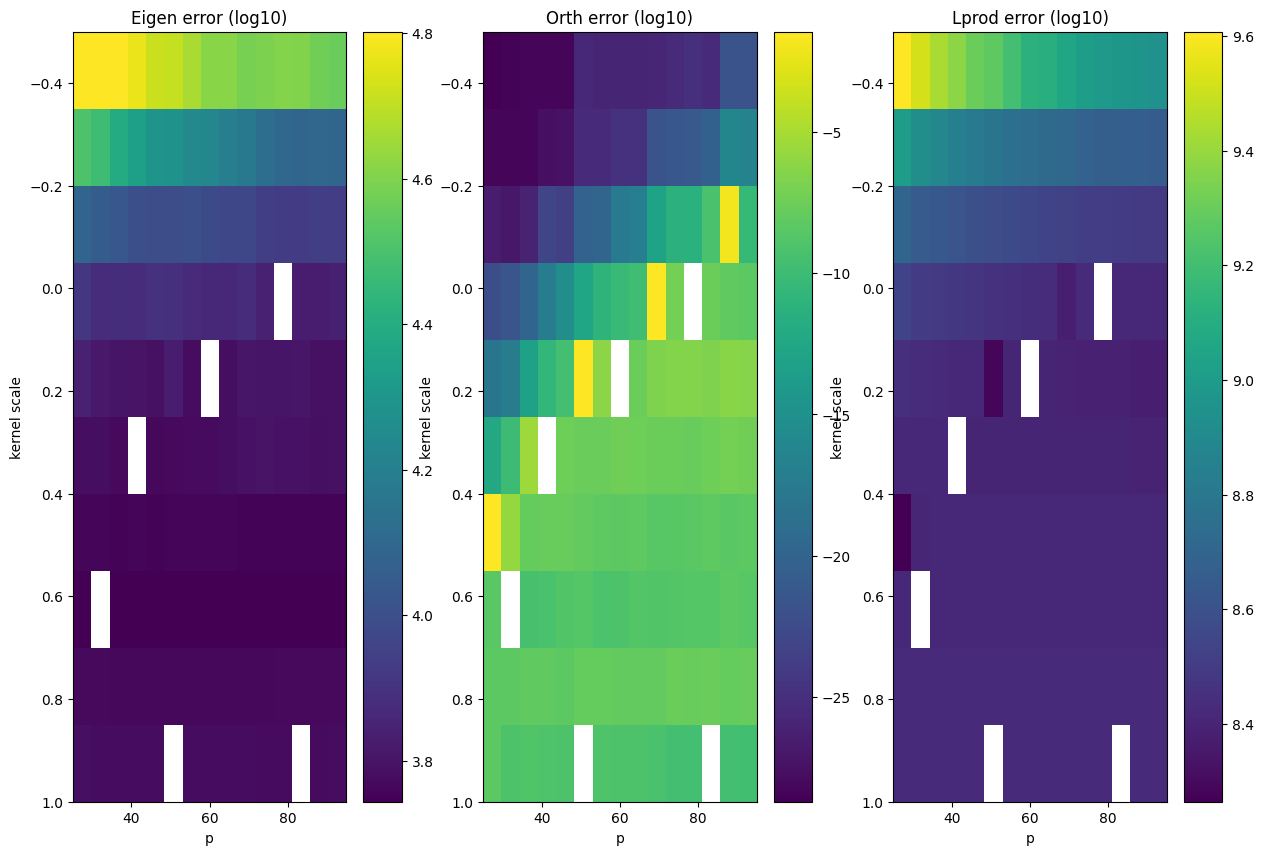

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15,10))

cax = ax[0].imshow(np.log10(eigen_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[0],shrink=1)
ax[0].set_title('Eigen error (log10)')

cax = ax[1].imshow(np.log10(orth_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[1],shrink=1)
ax[1].set_title('Orth error (log10)')

cax = ax[2].imshow(np.log10(L_prod_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[2],shrink=1)
ax[2].set_title('Lprod error (log10)')

ax[0].set_xlabel('p')
ax[0].set_ylabel('kernel scale')
ax[1].set_xlabel('p')
ax[1].set_ylabel('kernel scale')
ax[2].set_xlabel('p')
ax[2].set_ylabel('kernel scale')

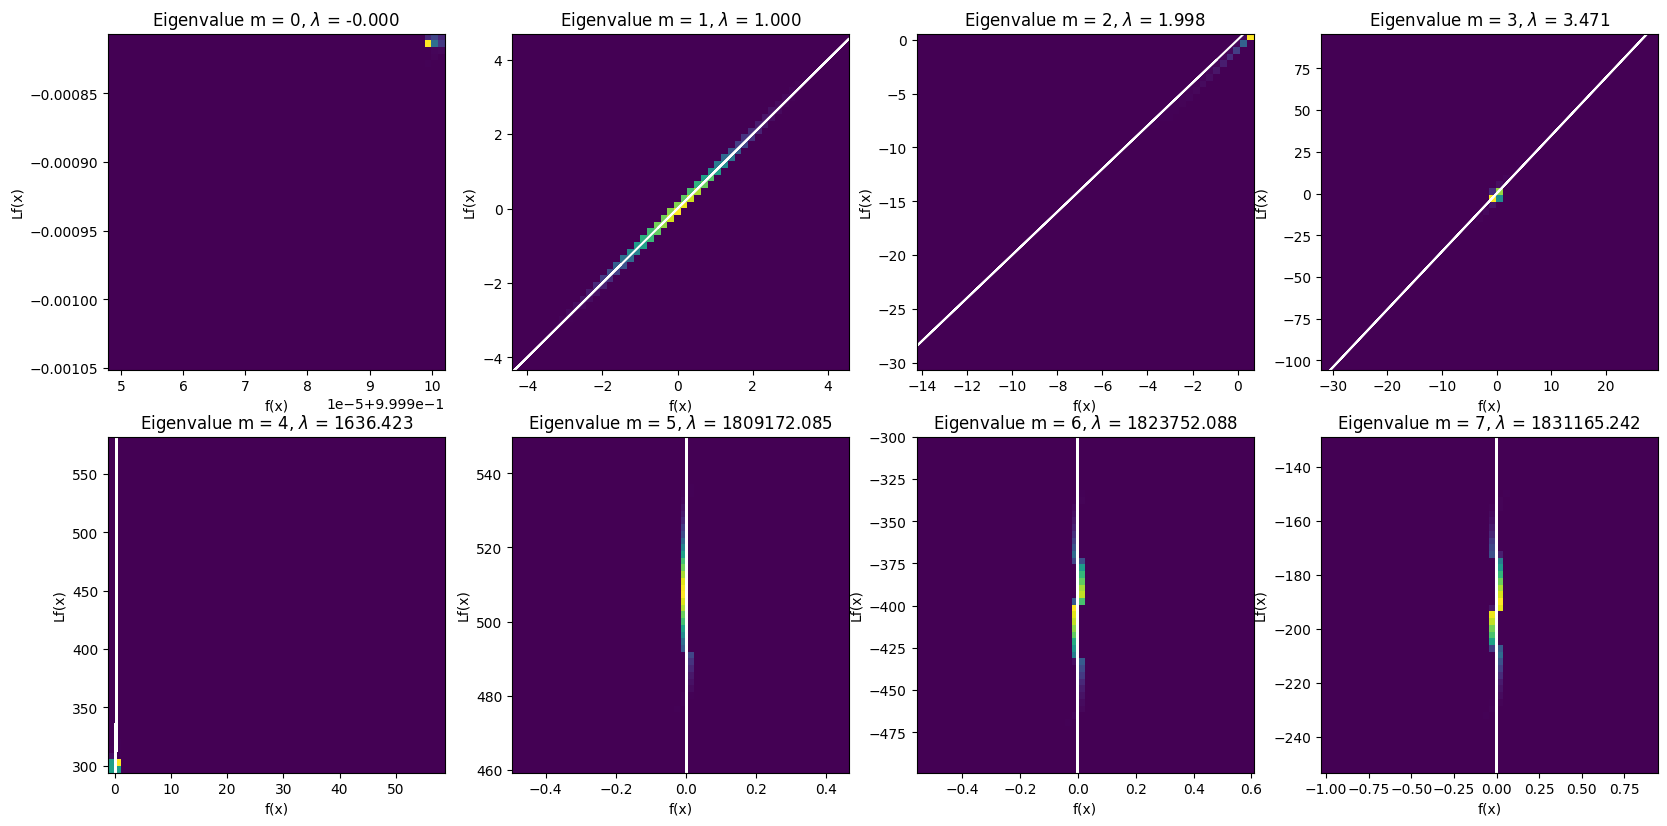

In [64]:
plot_eigenfunctions(x,solver,8)

In [12]:
grad = np.random.standard_normal((1000,100,10))

In [8]:
from itertools import product
import numpy as np

arrays = [np.array([1, 2]), np.array([3, 4]), [5]]
cartesian_product = np.array(list(product(*arrays)))

In [1]:
a = {'b': 1}
c = {'d': 4}

In [2]:
a | c

{'b': 1, 'd': 4}